In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from mat4py import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [2]:
data = loadmat('RW9.mat')

In [3]:
#Pulling out all the data from raw dataset

data2=data['data']

step=data2['step']

In [4]:
#Eight features
comment=pd.Series(step['comment'])
Type=pd.Series(step['type'])
current=pd.Series(step['current'])
time=pd.Series(step['time'])
relativeTime=pd.Series(step['relativeTime'])
voltage=pd.Series(step['voltage'])
temperature=pd.Series(step['temperature'])
date=pd.Series(step['date'])
#This df is our whole Dataframe
df=pd.DataFrame([comment,Type,date,current,time,relativeTime,voltage,temperature])
df=df.T
df.columns=['comment','Type','date','current','time','relativeTime','voltage','temperature']
#%%There are 15 different comment types 
comment_type = []
for i in comment:
    comment_type.append(i)
comment_type = set(comment_type)
comment_type=list(comment_type)

# pulling out data for the second period - pulsed period (pulse load(discharge) + pulse load(rest) )   

In [5]:
# Pulling out data of reference dsicharge
df_RDC = np.array(df[df['comment'] == 'reference discharge'])
df_RDC=pd.DataFrame(df_RDC)
df_RDC.columns=['comment','Type','date','current','time','relativeTime','voltage','temperature']

size_RDC=[]
for i in range(len(df_RDC)):
    size_RDC.append(len(df_RDC['relativeTime'][i]))

print (size_RDC[0:5])
df_RDC.head()

from statistics import mean
df_RDC['current_avg'] = df_RDC['current'].map(mean)
df_RDC['time_avg'] = df_RDC['time'].map(mean)              
df_RDC['relativeTime_avg'] = df_RDC['relativeTime'].map(mean)              
df_RDC['voltage_avg'] = df_RDC['voltage'].map(mean)              
df_RDC['temperature_avg'] = df_RDC['temperature'].map(mean)              
df_RDC.head()

[757, 756, 738, 736, 714]


,comment,Type,date,current,time,relativeTime,voltage,temperature,current_avg,time_avg,relativeTime_avg,voltage_avg,temperature_avg
0,reference discharge,D,06-Jan-2014 16:31:49,"[1.004, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[10509.699999999999, 10519.7, 10529.7, 10539.6...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.113, 4.099, 4.091, 4.085, 4.079, 4.075, 4.0...","[22.10602, 22.05919, 22.04357, 22.01235, 21.98...",0.999910,14289.690172,3780.030172,3.724370,24.955130
1,reference discharge,D,06-Jan-2014 21:32:56,"[1.003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[28575.879999999997, 28585.88, 28595.88, 28605...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.113, 4.099, 4.091, 4.085, 4.079, 4.074, 4.0...","[22.55875, 22.55875, 22.57436, 22.60559, 22.60...",0.999903,32350.868810,3775.028810,3.723958,24.701164
2,reference discharge,D,11-Jan-2014 12:30:19,"[1.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1...","[427288.81999999995, 427298.82, 427308.82, 427...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.11, 4.094, 4.085, 4.077, 4.071, 4.066, 4.06...","[22.63681, 22.63681, 22.65242, 22.66803, 22.68...",0.999871,430973.808374,3685.028374,3.703893,24.475288
3,reference discharge,D,11-Jan-2014 17:57:21,"[1.006, 0.999, 0.999, 1.0, 1.0, 1.0, 1.001, 1....","[446909.27, 446919.26999999996, 446929.27, 446...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.109, 4.093, 4.084, 4.076, 4.07, 4.065, 4.06...","[22.15285, 22.16847, 22.18408, 22.2153, 22.230...",0.999914,450584.266902,3675.036902,3.704291,24.128070
4,reference discharge,D,16-Jan-2014 04:50:19,"[1.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[830934.71, 830944.71, 830954.7100000001, 8309...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.106, 4.088, 4.078, 4.071, 4.064, 4.058, 4.0...","[21.73134, 21.73134, 21.76257, 21.77818, 21.79...",0.999896,834499.709328,3565.039328,3.693969,24.009902


# State of Health on Reference Discharge Period

# features

In [6]:
# discharging time
df_RDC['duration'] = 0
for i in range(0,len(df_RDC)):
    df_RDC['duration'][i] = max(df_RDC['relativeTime'][i]) - min(df_RDC['relativeTime'][i])



<ipython-input-6-e0c77e369904>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RDC['duration'][i] = max(df_RDC['relativeTime'][i]) - min(df_RDC['relativeTime'][i])


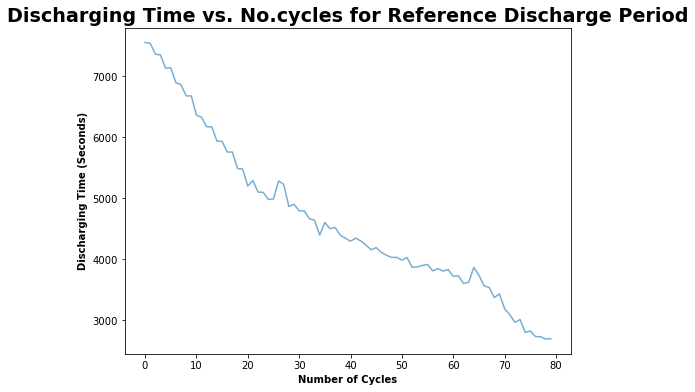

In [8]:
# ploting discharing time against number of cycles

duration = df_RDC['duration'].copy()
duration = [i for i in duration if i != 1199]

plt.figure(figsize=(8, 6)) 

plt.plot(duration, alpha
         = 0.6)
#plt.hlines(np.arange(100,601,100),0,184,colors='black', alpha = 0.3, linestyles='dashed',)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharging Time (Seconds)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharging Time vs. No.cycles for Reference Discharge Period',weight='bold')
plt.show()



####plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(15))


## internal resistence on pulsed load period

## internal resistence avg

In [20]:
# internal resistence

df_RDC['internal_resistence'] = pd.Series() 
for i in range(0,80):
    df_RDC['internal_resistence'][i] = (df_RDC['voltage'][0][0] - df_RDC['voltage'][i][0] )/df_RDC['current_avg'][i]
  



<ipython-input-20-731e4ef3c003>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_RDC['internal_resistence'] = pd.Series()
<ipython-input-20-731e4ef3c003>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RDC['internal_resistence'][i] = (df_RDC['voltage'][0][0] - df_RDC['voltage'][i][0] )/df_RDC['current_avg'][i]


In [21]:
df_RDC['voltage'][0][0]

4.113

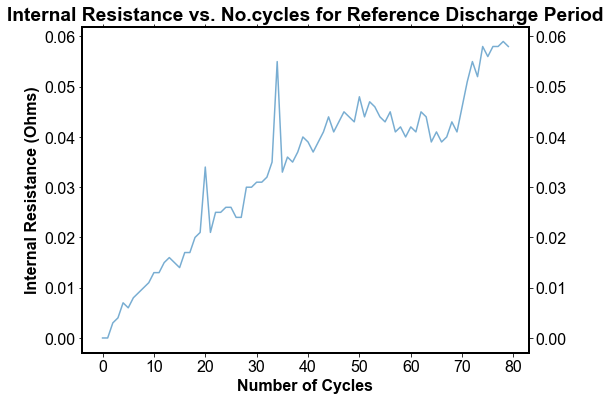

In [22]:
# plot internal resistance against cycles 
r = df_RDC['internal_resistence']

plt.figure(figsize=(8, 6)) 

plt.plot(r.index,r,alpha = 0.6)
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Internal Resistance (Ohms)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Internal Resistance vs. No.cycles for Reference Discharge Period',weight='bold')
plt.show()



In [ ]:
'''
# indicator for State of Health, an rearrangment of internal resistance
# initial internal resistence and End of Life internal resistsnce avg
# initial resistence is the first internal resistence value
init_r = r[0]
eof_r = 2.2 * init_r

soh = (eof_r - r) / (eof_r - init_r)
df_PL['soh'] = soh

plt.figure(figsize=(8, 6)) 

plt.plot(soh.index, soh, alpha = 0.6)
plt.ylabel('State of Health (%)',fontsize = 12)
plt.xlabel('Number of Cycles',fontsize = 12)
plt.title('Dynamics of State of Health vs. No.Cycles', c = 'black',fontsize = 14,weight='bold')
plt.hlines(np.arange(0.0,1.2,0.2),0,184,colors='black', alpha = 0.3, linestyles='dashed')

plt.text(-7,-0.5, 'https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/\nBrian Bole, Chetan Kulkarni, and Matthew Daigle, \n“Adaptation of an Electrochemistry-based Li-Ion Battery Model to Account for Deterioration Observed Under Randomized Use”, \nin the proceedings of the Annual Conference of the Prognostics and Health Management Society, 2014',fontsize=7)   
plt.show()
'''


In [222]:
df_RDC

,comment,Type,date,current,time,relativeTime,voltage,temperature,current_avg,time_avg,relativeTime_avg,voltage_avg,temperature_avg,duration,internal_resistence,soc,capacity
0,reference discharge,D,06-Jan-2014 16:31:49,"[1.004, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[10509.699999999999, 10519.7, 10529.7, 10539.6...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.113, 4.099, 4.091, 4.085, 4.079, 4.075, 4.0...","[22.10602, 22.05919, 22.04357, 22.01235, 21.98...",0.999910,1.428969e+04,3780.030172,3.724370,24.955130,7552,0.000000,1.000000,7551.321617
1,reference discharge,D,06-Jan-2014 21:32:56,"[1.003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[28575.879999999997, 28585.88, 28595.88, 28605...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.113, 4.099, 4.091, 4.085, 4.079, 4.074, 4.0...","[22.55875, 22.55875, 22.57436, 22.60559, 22.60...",0.999903,3.235087e+04,3775.028810,3.723958,24.701164,7541,0.000000,0.997586,7540.271835
2,reference discharge,D,11-Jan-2014 12:30:19,"[1.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1...","[427288.81999999995, 427298.82, 427308.82, 427...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.11, 4.094, 4.085, 4.077, 4.071, 4.066, 4.06...","[22.63681, 22.63681, 22.65242, 22.66803, 22.68...",0.999871,4.309738e+05,3685.028374,3.703893,24.475288,7361,0.003000,0.880078,7360.052446
3,reference discharge,D,11-Jan-2014 17:57:21,"[1.006, 0.999, 0.999, 1.0, 1.0, 1.0, 1.001, 1....","[446909.27, 446919.26999999996, 446929.27, 446...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.109, 4.093, 4.084, 4.076, 4.07, 4.065, 4.06...","[22.15285, 22.16847, 22.18408, 22.2153, 22.230...",0.999914,4.505843e+05,3675.036902,3.704291,24.128070,7347,0.004000,0.882408,7346.371113
4,reference discharge,D,16-Jan-2014 04:50:19,"[1.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[830934.71, 830944.71, 830954.7100000001, 8309...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.106, 4.088, 4.078, 4.071, 4.064, 4.058, 4.0...","[21.73134, 21.73134, 21.76257, 21.77818, 21.79...",0.999896,8.344997e+05,3565.039328,3.693969,24.009902,7129,0.007001,0.821960,7128.261140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,reference discharge,D,27-May-2014 15:38:53,"[1.002, 0.999, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0,...","[12207354.1, 12207364.1, 12207374.1, 12207384....","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.057, 3.999, 3.98, 3.965, 3.953, 3.942, 3.93...","[32.04596, 32.06141, 32.07687, 32.12325, 31.98...",0.999919,1.220877e+07,1415.025810,3.561556,35.245658,2825,0.056005,0.046492,2824.771215
76,reference discharge,D,30-May-2014 04:54:20,"[1.003, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1...","[12427168.28, 12427178.28, 12427188.28, 124271...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.055, 3.994, 3.975, 3.959, 3.947, 3.935, 3.9...","[32.10779, 32.10779, 32.13871, 32.16962, 32.21...",0.999869,1.242854e+07,1370.023673,3.555913,35.343405,2735,0.058008,0.013441,2734.641964
77,reference discharge,D,30-May-2014 13:14:43,"[1.004, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1...","[12457189.16, 12457199.16, 12457209.16, 124572...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.055, 3.996, 3.977, 3.962, 3.949, 3.938, 3.9...","[31.59765, 31.62856, 31.6904, 31.72132, 31.767...",0.999873,1.245856e+07,1370.010073,3.555058,34.768506,2731,0.058007,0.008436,2730.652418
78,reference discharge,D,02-Jun-2014 01:19:33,"[1.003, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1...","[12672750.22, 12672760.219999999, 12672770.22,...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.054, 3.994, 3.975, 3.96, 3.947, 3.935, 3.92...","[32.40151, 32.43242, 32.44788, 32.4788, 32.494...",0.999889,1.267410e+07,1350.024723,3.554225,35.719393,2695,0.059007,0.003557,2694.701661


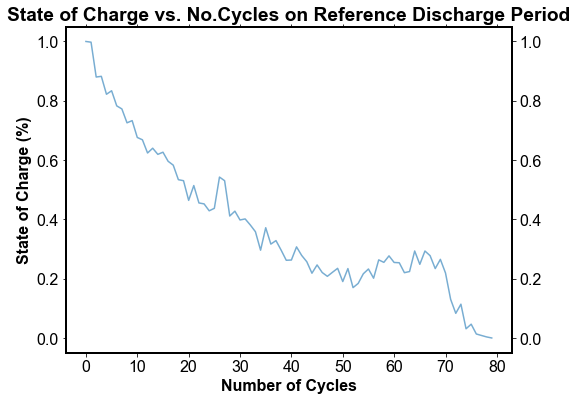

In [24]:
# state of charge voltage-based on load period

# state of charge voltage based
df_RDC['soc'] = (df_RDC['voltage_avg'] - min(df_RDC['voltage_avg']))/(max(df_RDC['voltage_avg']) - min(df_RDC['voltage_avg']))
soc = df_RDC['soc']
plt.figure(figsize=(8, 6)) 

plt.plot( soc, alpha = 0.6)
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('State of Charge vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()

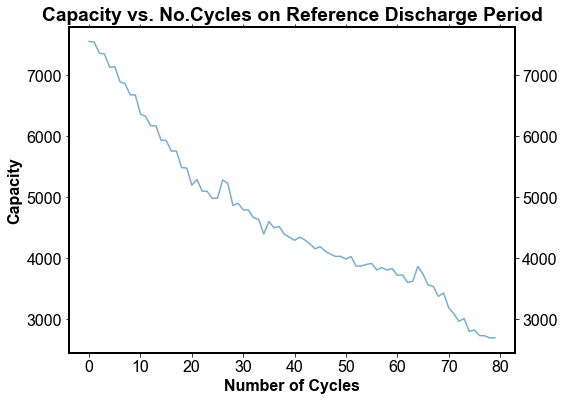

In [23]:
# capacity on reference discharge


df_RDC['capacity'] = (df_RDC['current_avg'] *  df_RDC['duration'] )
capacity = df_RDC['capacity']
plt.figure(figsize=(8, 6)) 

plt.plot( capacity, alpha = 0.6)


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Capacity',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Capacity vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()

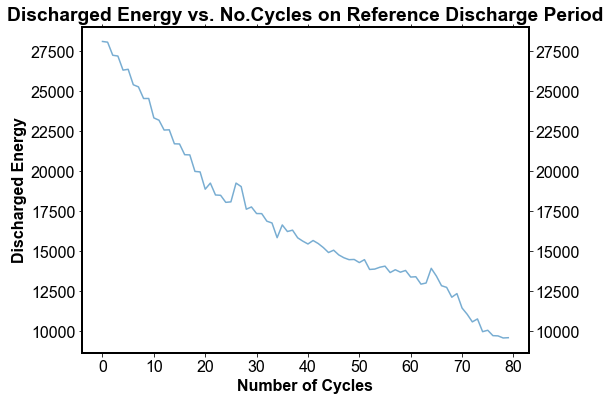

In [25]:
# discharge energy changed
discharge_energy = list()
for i in range(len(df_RDC)):
    q =  (df_RDC['current_avg'][i] * df_RDC['duration'][i] * df_RDC['voltage_avg'][i])
    discharge_energy.append(q)
    
plt.figure(figsize=(8, 6)) 

plt.plot( discharge_energy, alpha = 0.6)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharged Energy',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharged Energy vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()


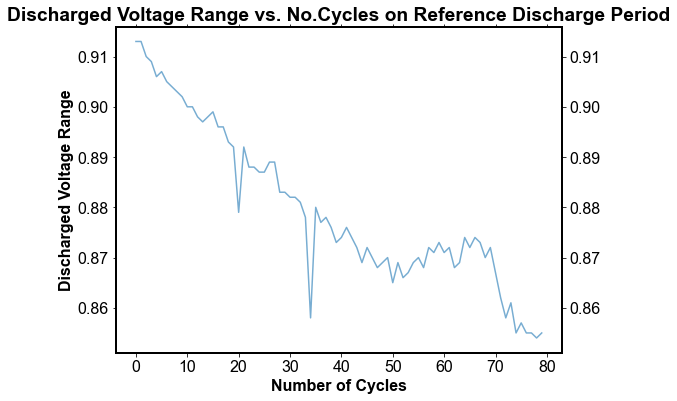

In [26]:

# discharge voltage range
discharge_range = list()
for i in range(0,80):
    v_r =  (max(df_RDC['voltage'][i]) - min(df_RDC['voltage'][i]))
    discharge_range.append(v_r)
    
plt.figure(figsize=(8, 6)) 

plt.plot( discharge_range, alpha = 0.6)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharged Voltage Range',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharged Voltage Range vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()

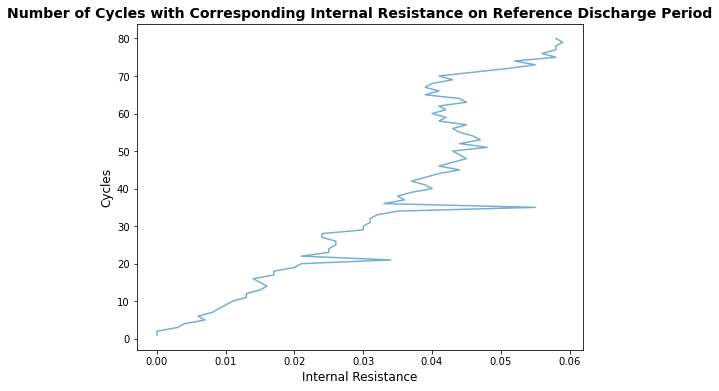

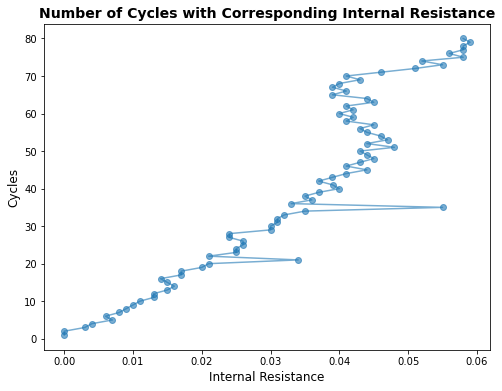

In [221]:
# plot of cycle vs. internal resistance

plt.figure(figsize=(8, 6)) 

plt.plot( soh_rdc['internal_resistance'],soh_rdc['cycle'], alpha = 0.6)
plt.ylabel('Cycles',fontsize = 12)
plt.xlabel('Internal Resistance',fontsize = 12)
plt.title('Number of Cycles with Corresponding Internal Resistance on Reference Discharge Period', c = 'black',fontsize = 14,weight='bold')
#plt.hlines(np.arange(0.0,0.45,0.05),0,184,colors='black', alpha = 0.3, linestyles='dashed')

plt.show()


plt.figure(figsize=(8, 6)) 

plt.plot( soh_rdc['internal_resistance'],soh_rdc['cycle'],marker = 'o', alpha = 0.6)
plt.ylabel('Cycles',fontsize = 12)
plt.xlabel('Internal Resistance',fontsize = 12)
plt.title('Number of Cycles with Corresponding Internal Resistance', c = 'black',fontsize = 14,weight='bold')
#plt.hlines(np.arange(0.0,0.45,0.05),0,184,colors='black', alpha = 0.3, linestyles='dashed')

plt.show()


# define failure threshold

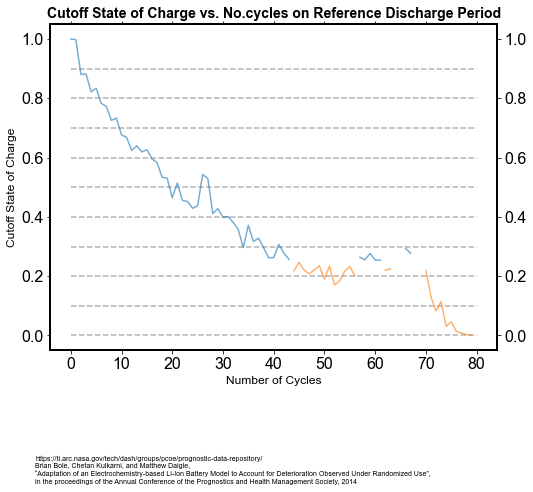

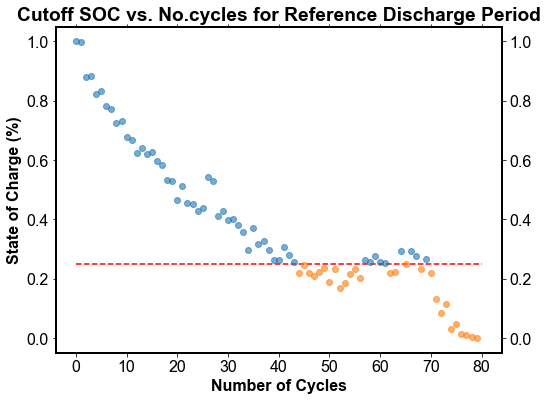

In [27]:
# define failure threshold


cutoff = 0.25 * soc[0]

unhealthy = np.ma.masked_where(soc > cutoff, soc)
healthy = np.ma.masked_where(soc <= cutoff, soc)

# plot soc against cycles 
plt.figure(figsize=(8, 6)) 

plt.plot(soc.index,healthy,soc.index,unhealthy, alpha = 0.6)
plt.ylabel('Cutoff State of Charge',fontsize = 12)
plt.xlabel('Number of Cycles',fontsize = 12)
plt.title('Cutoff State of Charge vs. No.cycles on Reference Discharge Period', c = 'black',fontsize = 14,weight='bold')
plt.hlines(np.arange(0.0,1,0.1),0,80,colors='black', alpha = 0.3, linestyles='dashed',)

plt.text(-7,-0.5, 'https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/\nBrian Bole, Chetan Kulkarni, and Matthew Daigle, \n“Adaptation of an Electrochemistry-based Li-Ion Battery Model to Account for Deterioration Observed Under Randomized Use”, \nin the proceedings of the Annual Conference of the Prognostics and Health Management Society, 2014',fontsize=7)   
plt.show()


# scatter plot

plt.figure(figsize=(8, 6)) 

plt.plot(soc.index,healthy,'o', soc.index,unhealthy,'o', alpha = 0.6)
plt.hlines(0.25,0,80,colors='red', linestyles='dashed',)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Cutoff SOC vs. No.cycles for Reference Discharge Period',weight='bold')
plt.show()


In [226]:
# find the cutoff cycle, the nearest cycle of the cutoff soc
cutoff_cycle = (np.abs(soc-cutoff)).argmin()
print('cutoff cycle is No.', cutoff_cycle)

# plot failure based on cutoff cycle



cutoff cycle is No. 65


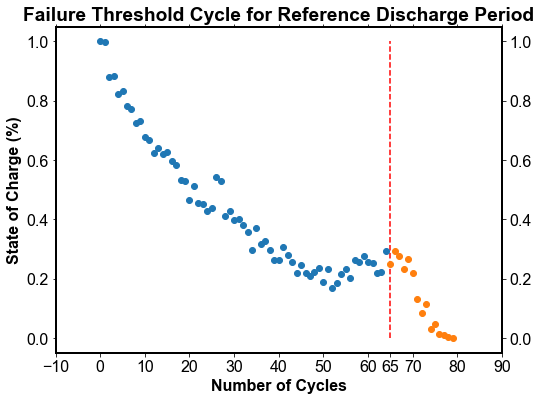

In [28]:
# plot failure based on cutoff cycle


plt.figure(figsize=(8, 6))
plt.plot(soc[0:65].index,soc[0:65],'o',soc[65:80].index,soc[65:80],'o')

plt.vlines(65,0,1, colors='red',linestyles='dashed')
plt.xticks(list(plt.xticks()[0]) + [65])


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Failure Threshold Cycle for Reference Discharge Period',weight='bold')
plt.show()

## prepare estimation dataframe

In [241]:
soh_rdc

,current,voltage_ocv,voltage_bat,internal_resistance,duration,temperature,soc,discharge_energy,discharge_range,capacity,cycle
0,0.999910,3.72437,3.724370,0.000000,7552.0,24.955130,1.000000,28123.914793,0.913,7551.321617,1.0
1,0.999903,3.72437,3.723958,0.000000,7541.0,24.701164,0.997586,28079.653147,0.913,7540.271835,2.0
2,0.999871,3.72437,3.703893,0.003000,7361.0,24.475288,0.880078,27260.846395,0.910,7360.052446,3.0
3,0.999914,3.72437,3.704291,0.004000,7347.0,24.128070,0.882408,27213.094639,0.909,7346.371113,4.0
4,0.999896,3.72437,3.693969,0.007001,7129.0,24.009902,0.821960,26331.577013,0.906,7128.261140,5.0
...,...,...,...,...,...,...,...,...,...,...,...
75,0.999919,3.72437,3.561556,0.056005,2825.0,35.245658,0.046492,10060.581824,0.857,2824.771215,76.0
76,0.999869,3.72437,3.555913,0.058008,2735.0,35.343405,0.013441,9724.148163,0.855,2734.641964,77.0
77,0.999873,3.72437,3.555058,0.058007,2731.0,34.768506,0.008436,9707.628221,0.855,2730.652418,78.0
78,0.999889,3.72437,3.554225,0.059007,2695.0,35.719393,0.003557,9577.576258,0.854,2694.701661,79.0


In [32]:
# State of Health dataframe on reference discharge period
# soh
# soc
# discharge_energy
c = list()
v_ocv = list()
v_bat = list()
cycle = np.arange(1,81)
d = list()
t = list()
for i in range(0,80):
    c.append(df_RDC['current_avg'][i])
    v_ocv.append(df_RDC['voltage_avg'][0])
    v_bat.append(df_RDC['voltage_avg'][i])
    d.append(df_RDC['duration'][i])
    t.append(df_RDC['temperature_avg'][i])

features = ['current','voltage_ocv','voltage_bat','internal_resistance','duration','temperature','soc','discharge_energy','discharge_range','capacity']
soh_rdc = pd.DataFrame([c,v_ocv,v_bat,r,d,t,soc,discharge_energy,discharge_range,capacity,cycle])
soh_rdc = np.transpose(soh_rdc)
soh_rdc.columns = ['current','voltage_ocv','voltage_bat','internal_resistance','duration','temperature','soc','discharge_energy','discharge_range','capacity','cycle']

np.random.seed(10)
threshold = np.random.rand(len(soh_rdc)) < 0.8
train = soh_rdc[threshold]
test = soh_rdc[~threshold]

X = train[features].astype(float)
Y = train['cycle'].astype(float)

X_test = test[features].astype(float)
Y_test = test['cycle'].astype(float) 


In [33]:
# select features
def minAIC_OLS(X,Y):
    variables = X.columns
    model = sm.OLS(Y,X[variables]).fit()
    while True:
        print(f'old model AIC：{model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        removed = variables[model.pvalues == maxp].values
        print(f'consider a model with these variables removed:{removed}')
        newmodel = sm.OLS(Y,X[newvariables]).fit()
        print(f'new model AIC :{newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model, variables

In [34]:
model_new, features_new = minAIC_OLS(X,Y)
model_new.summary()
print(features_new)

old model AIC：350.96697692703765
consider a model with these variables removed:['soc']
new model AIC :350.966976927344
Index(['current', 'voltage_ocv', 'voltage_bat', 'internal_resistance',
       'duration', 'temperature', 'soc', 'discharge_energy', 'discharge_range',
       'capacity'],
      dtype='object')


## random forest

In [35]:
from statistics import mean
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score


In [36]:
X

,current,voltage_ocv,voltage_bat,internal_resistance,duration,temperature,soc,discharge_energy,discharge_range,capacity
0,0.999910,3.72437,3.724370,0.000000,7552.0,24.955130,1.000000,28123.914793,0.913,7551.321617
1,0.999903,3.72437,3.723958,0.000000,7541.0,24.701164,0.997586,28079.653147,0.913,7540.271835
2,0.999871,3.72437,3.703893,0.003000,7361.0,24.475288,0.880078,27260.846395,0.910,7360.052446
3,0.999914,3.72437,3.704291,0.004000,7347.0,24.128070,0.882408,27213.094639,0.909,7346.371113
4,0.999896,3.72437,3.693969,0.007001,7129.0,24.009902,0.821960,26331.577013,0.906,7128.261140
...,...,...,...,...,...,...,...,...,...,...
73,0.999964,3.72437,3.573079,0.052002,3014.0,35.364958,0.113975,10768.869769,0.861,3013.890581
74,0.999901,3.72437,3.558908,0.058006,2802.0,35.174338,0.030981,9971.069526,0.855,2801.721787
75,0.999919,3.72437,3.561556,0.056005,2825.0,35.245658,0.046492,10060.581824,0.857,2824.771215
77,0.999873,3.72437,3.555058,0.058007,2731.0,34.768506,0.008436,9707.628221,0.855,2730.652418


# SELECT depth

In [37]:
depth = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy = list()
accuracy_modified = list()
mse = []
r2 = []
for d in depth:
    clf = DecisionTreeRegressor(random_state=0, criterion = "mse", splitter = "best", max_depth = d)
    model = clf.fit(X[features_new], Y) # Use the training data to build 
    y_test_pred = np.round(model.predict(X_test[features_new]))
    m = mean_squared_error(Y_test, y_test_pred)
    r = r2_score(Y_test, y_test_pred)

    mse.append(m)
    r2.append(r)
    print('depth:',d)
    print ("Test MSE on Reference Discharge Period ", m)
    print ("R2 on Reference Discharge Period ", r)
# cycle prediction accuracy
    y_pred = model.predict(soh_rdc[features_new].astype(float))
    y_pred = np.round(y_pred)

    soh_rdc['predict'] = y_pred

    correct = 0
    actual = list()
    pred = list()
    for i in range(len(soh_rdc)):
        if soh_rdc['predict'][i] == soh_rdc['cycle'][i]:
            correct += 1
        else:
            actual.append(soh_rdc['cycle'][i])
            pred.append(soh_rdc['predict'][i])
           
    acc = correct/80
    print('Accuracy for reference discharge cycle prediction before modified is:',acc)
    accuracy.append(acc)

# if prediction error is within one cycle, roughly considered as correct

    for i in range(len(soh_rdc)):
        if abs(soh_rdc['predict'][i] - soh_rdc['cycle'][i]) == 1:
            correct += 1
        
    acc_mod = correct/80
    print('Accuracy for cycle prediction after modified is:',acc_mod)
    accuracy_modified.append(acc_mod)
    print('-' * 50)



depth: 5
Test MSE on Reference Discharge Period  10.75
R2 on Reference Discharge Period  0.971642606159902
Accuracy for reference discharge cycle prediction before modified is: 0.4
Accuracy for cycle prediction after modified is: 0.7875
--------------------------------------------------
depth: 6
Test MSE on Reference Discharge Period  13.1875
R2 on Reference Discharge Period  0.9652127319752285
Accuracy for reference discharge cycle prediction before modified is: 0.6625
Accuracy for cycle prediction after modified is: 0.8625
--------------------------------------------------
depth: 7
Test MSE on Reference Discharge Period  10.9375
R2 on Reference Discharge Period  0.9711480004533886
Accuracy for reference discharge cycle prediction before modified is: 0.7625
Accuracy for cycle prediction after modified is: 0.9
--------------------------------------------------
depth: 8
Test MSE on Reference Discharge Period  10.9375
R2 on Reference Discharge Period  0.9711480004533886
Accuracy for refe

In [38]:

# best depth is 9
for d in depth:
    clf = DecisionTreeRegressor(random_state=0, criterion = "mse", splitter = "best", max_depth = 9)
    model = clf.fit(X[features_new], Y) # Use the training data to build 
    y_test_pred = np.round(model.predict(X_test[features_new]))
    
    MSE = mean_squared_error(Y_test, y_test_pred)
    R = r2_score(Y_test, y_test_pred)


    
print ("MSE Pulsed Load ", MSE)
print ("R2 Pulsed Load ", R)

MSE Pulsed Load  10.75
R2 Pulsed Load  0.971642606159902


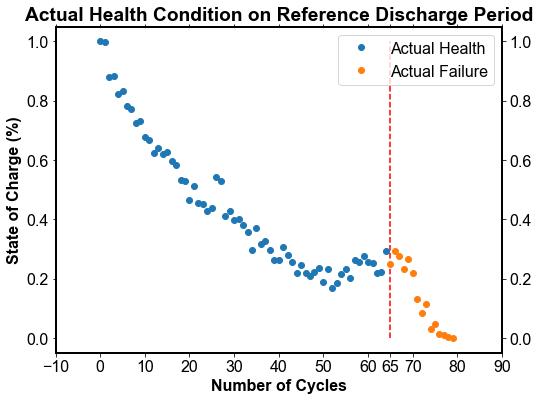

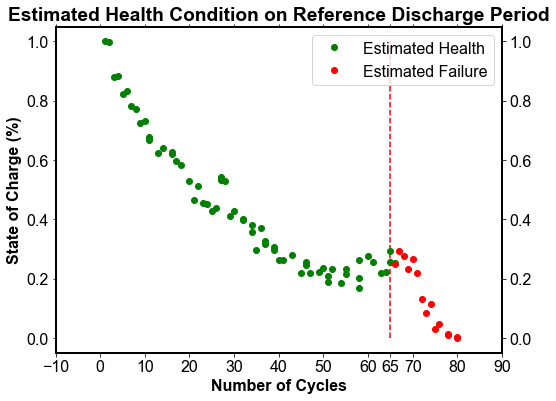

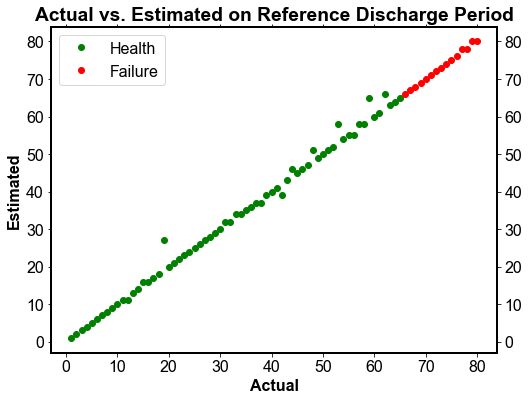

In [41]:
#actual data


plt.figure(figsize=(8, 6))
plt.plot(soc[0:65].index,soc[0:65],'o',label = 'Actual Health')
plt.plot(soc[65:80].index,soc[65:80],'o',label = 'Actual Failure')
plt.legend()

plt.vlines(65,0,1, colors='red',linestyles='dashed')

plt.xticks(list(plt.xticks()[0]) + [65])


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Actual Health Condition on Reference Discharge Period',weight='bold')
plt.show()

# predicted data
y_pred = model.predict(soh_rdc[features_new].astype(float))
y_pred = np.round(y_pred)
soh_rdc['predict'] = y_pred


plt.figure(figsize=(8, 6)) 

plt.plot(y_pred[0:65],soc[0:65],'o',label = 'Estimated Health', c = 'green')
plt.plot(y_pred[65:80],soc[65:80],'o',label = 'Estimated Failure', c = 'red')
plt.legend()

plt.vlines(65,0,1, colors='red',linestyles='dashed')
plt.xticks(list(plt.xticks()[0]) + [65])
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Estimated Health Condition on Reference Discharge Period',weight='bold')
plt.show()

# compare actual and predicted


plt.figure(figsize=(8, 6)) 

plt.plot(soh_rdc['cycle'][0:65],y_pred[0:65],'o',label = 'Health', c = 'green')
plt.plot(soh_rdc['cycle'][65:80],y_pred[65:80],'o',label = 'Failure', c = 'red')
plt.legend()

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Estimated',weight='bold')
plt.xlabel('Actual',weight='bold')
plt.title('Actual vs. Estimated on Reference Discharge Period',weight='bold')
plt.show()


## cycle prediciton accuracy

In [116]:
'''# cycle prediciton accuracy
correct = 0
actual = list()
pred = list()
for i in range(len(soh_df)):
    if soh_df['predict'][i] == soh_df['cycle'][i]:
        correct += 1
    else:
        actual.append(soh_df['cycle'][i])
        pred.append(soh_df['predict'][i])
           
accuracy = correct/184
print('Accuracy for cycle prediction before modified is:',accuracy)

# if prediction error is within one cycle, roughly considered as correct

for i in range(len(soh_df)):
    if abs(soh_df['predict'][i] - soh_df['cycle'][i]) == 1:
        correct += 1
        
accuracy = correct/184
print('Accuracy for cycle prediction after modified is:',accuracy)
'''

Accuracy for cycle prediction before modified is: 0.8043478260869565
Accuracy for cycle prediction after modified is: 0.8315217391304348


In [273]:
1+1

2

## Check result

In [304]:
np.random.seed(20)

sample_data = soh_rdc.sample(n = 10)
sample_data = sample_data.reset_index(drop = True)

sample_x = sample_data[features_new].astype(float)
sample_y = sample_data['cycle']

sample_y_pred = np.round(model.predict(sample_x))

import sys
from termcolor import colored, cprint
  
for i in range(len(sample_y_pred)):
    print('For the follwing input data on reference discharge period:')
    print(sample_x.iloc[i].to_string())
    print(colored('The estimated current cycle is at'), colored('No.','green'), colored(int(sample_y_pred[i]),'green'))
    if sample_y_pred[i] < 65:
        print(colored('There are'), colored(65 - int(sample_y_pred[i]),'blue'), colored('cycles left to reach failure threshold'))
    else:
        print(colored('There are'), colored(int(sample_y_pred[i]) - 65,'red'), colored('cycles overused beyond the failure threshold'))

    print(colored('The actual current cycle is at'), colored('No.','green'), colored(int(int(sample_y[i])),'green'))
    if sample_y[i] < 65:
        print(colored('There are actual'), colored(65 - int(sample_y[i]) ,'blue'), colored('cycles left to reach failure threshold'))

    else:
        print(colored('There are actual'), colored(int(sample_y[i]) - 65,'red'), colored('cycles overused beyond the failure threshold'))

    if sample_y_pred[i] == sample_y[i]:
        print(colored('Correct Estimation','yellow'))
    else:
        print(colored('Error Estimation', 'yellow'))
    print('-----------------------------------------------------------------------------------------')


For the follwing input data on reference discharge period:
current                    0.999920
voltage_ocv                3.724370
voltage_bat                3.630840
internal_resistance        0.025002
duration                5096.000000
temperature               31.399608
soc                        0.452245
discharge_energy       18501.273681
discharge_range            0.888000
capacity                5095.591123
The estimated current cycle is at No. 24
There are 41 cycles left to reach failure threshold
The actual current cycle is at No. 24
There are actual 41 cycles left to reach failure threshold
Correct Estimation
-----------------------------------------------------------------------------------------
For the follwing input data on reference discharge period:
current                    0.999907
voltage_ocv                3.724370
voltage_bat                3.604222
internal_resistance        0.037003
duration                4396.000000
temperature               31.292950
soc    

In [293]:
from termcolor import colored, cprint

## recursive least square

In [279]:

import statsmodels.api as sm
mod = sm.RecursiveLS(X, Y)
rls = mod.fit()

print(rls.summary())


                           Statespace Model Results                           
Dep. Variable:                current   No. Observations:                  148
Model:                    RecursiveLS   Log Likelihood                -117.403
Date:                Thu, 06 May 2021   R-squared:                       0.743
Time:                        19:50:33   AIC                            236.805
Sample:                             0   BIC                            239.802
                                - 148   HQIC                           238.023
Covariance Type:            nonrobust   Scale                            0.259
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cycle          0.0080      0.000     20.596      0.000       0.007       0.009
Ljung-Box (L1) (Q):     111.48, nan, nan, nan, nan, nan, nan, nan   Jarque-Bera (JB):   122.14, 55.12, 55.12, 55.12, 55.12, 55.12, 

/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)
/Users/shuofeng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:672: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


In [280]:
y_test_pred = rls.predict(X_test)

mse = mean_squared_error(Y_test, y_test_pred)
r_square = model.score(X_test, Y_test)
print ('MSE is:',mse)
print ('R^2 is:',r_square)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

## linear regression 

intercept: 182755.5292412002
coef: [ 1.38757227e+05 -1.65236287e+05  6.91756272e+04  1.66502236e+05
 -1.07635298e-02  3.64006056e+00  8.14870752e+04 -5.19234992e+02]
R^2 of pulsed load resistance on testing set: 0.9245657229770265
mse of pulsed load resistance on testing set: 162.77777777777777


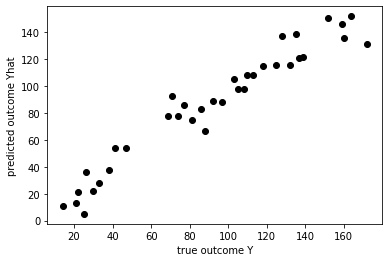

-------------------------------------------


In [278]:
# linear regression not accurate

regression = linear_model.LinearRegression()
linearmodel = regression.fit(X,Y)

print('intercept:', linearmodel.intercept_)
print('coef:', linearmodel.coef_)

r_square_test = linearmodel.score(X_test, Y_test)

print('R^2 of pulsed load resistance on testing set:', r_square_test)

# prediction
y_test_pred = linearmodel.predict(X_test)
y_test_pred = np.round(y_test_pred)
# mse
mse = mean_squared_error(Y_test, y_test_pred)
print('mse of pulsed load resistance on testing set:', mse)
plot_fit(Y_test, y_test_pred)
print('-------------------------------------------')

    

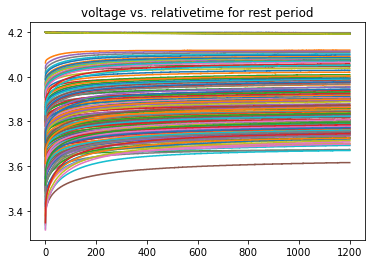

In [122]:
# plot of voltage vs relativetimes 
for i in range(0,368,2):
    plt.plot(df_PL['voltage'][i])
    plt.title('voltage vs. relativetime for rest period')
    


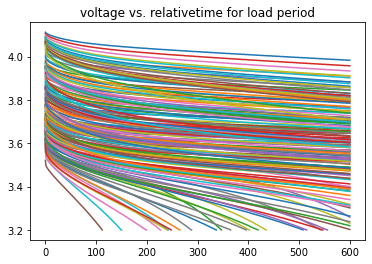

In [123]:
for i in range(1,368,2):
    plt.plot(df_PL['voltage'][i])
    plt.title('voltage vs. relativetime for load period')


intercept: 243.1077463617068
coef: [-2.41244682e+02 -4.00649298e-02]
R^2 of reference discharge health rate on testing set: 0.8730258681259772
mse of reference discharge health rate on testing set: 0.0035090741992533014


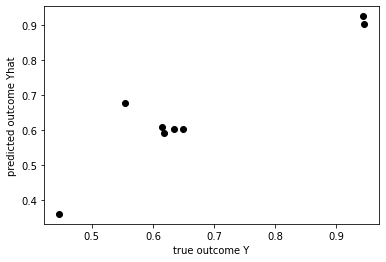

-------------------------------------------


In [169]:
# multivariate regression to predict health rate
np.random.seed(3)
threshold = np.random.rand(len(df_RDC)) < 0.8
train = df_RDC[threshold]
test = df_RDC[~threshold]

X = train[variables].astype(float)
Y = train['duration_rate'].astype(float)

X_test = test[variables].astype(float)
Y_test = test['duration_rate'].astype(float) #output /predictor

regression = linear_model.LinearRegression()
linearmodel = regression.fit(X,Y)

print('intercept:', linearmodel.intercept_)
print('coef:', linearmodel.coef_)

r_square_test = linearmodel.score(X_test, Y_test)

print('R^2 of reference discharge health rate on testing set:', r_square_test)

# prediction
y_pred_test = linearmodel.predict(X_test)

# mse
mse = mean_squared_error(Y_test, y_pred_test)
print('mse of reference discharge health rate on testing set:', mse)
plot_fit(Y_test, y_pred_test)
print('-------------------------------------------')


In [170]:
variables = ['current_avg','temperature_avg']

intercept: 0.9963636733802359
coef: [-5.26146781e-01  1.24984114e-04]
R^2 of Pulsed Load health rate on testing set: 0.9703616207130841
mse of Pulsed Load health rate on testing set: 0.002037011700645532


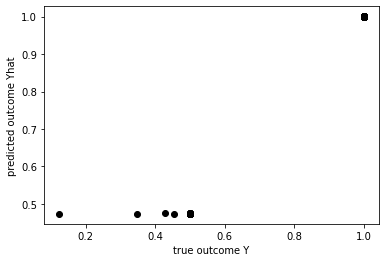

-------------------------------------------


In [171]:
# multivariate regression to predict health rate on pulsed load period
np.random.seed(4)
threshold = np.random.rand(len(df_PL)) < 0.8
train = df_PL[threshold]
test = df_PL[~threshold]

X = train[variables].astype(float)
Y = train['duration_rate'].astype(float)

X_test = test[variables].astype(float)
Y_test = test['duration_rate'].astype(float) #output /predictor

regression = linear_model.LinearRegression()
linearmodel = regression.fit(X,Y)

print('intercept:', linearmodel.intercept_)
print('coef:', linearmodel.coef_)

r_square_test = linearmodel.score(X_test, Y_test)

print('R^2 of Pulsed Load health rate on testing set:', r_square_test)

# prediction
y_pred_test = linearmodel.predict(X_test)

# mse
mse = mean_squared_error(Y_test, y_pred_test)
print('mse of Pulsed Load health rate on testing set:', mse)
plot_fit(Y_test, y_pred_test)
print('-------------------------------------------')


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_all_normalized = df_all.copy()
df_all_normalized = df_all_normalized.iloc[:,8:].astype(float)
scaler = MinMaxScaler().fit(df_all_normalized)
df_all_normalized_scaled = scaler.transform(df_all_normalized)
df_all_normalized_scaled = pd.DataFrame(df_all_normalized_scaled, columns = df_all_normalized.columns)
df_all_normalized_scaled.head()

# Set of variables

In [134]:
variables = ['current_avg','time_avg','relativeTime_avg','temperature_avg']

# Multivariate regression on whole data set

# Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
 

# random walk
random_walk_normalized = random_walk_df.copy()
random_walk_normalized = random_walk_normalized.iloc[:,4:].astype(float)

scaler = MinMaxScaler().fit(random_walk_normalized)
random_walk_normalized_scaled = scaler.transform(random_walk_normalized) 
random_walk_normalized_scaled = pd.DataFrame(random_walk_normalized_scaled, columns = random_walk_normalized.columns)

# reference discharge
reference_discharge_normalized = reference_discharge_df.copy()
reference_discharge_normalized = reference_discharge_normalized.iloc[:,3:].astype(float)

scaler = MinMaxScaler().fit(reference_discharge_normalized)
reference_discharge_normalized_scaled = scaler.transform(reference_discharge_normalized) 
reference_discharge_normalized_scaled = pd.DataFrame(reference_discharge_normalized_scaled, columns = reference_discharge_normalized.columns)

# pulsed load
pulsed_load_normalized = pulsed_load_df.copy()
pulsed_load_normalized = pulsed_load_normalized.iloc[:,3:].astype(float)

scaler = MinMaxScaler().fit(pulsed_load_normalized)
pulsed_load_normalized_scaled = scaler.transform(pulsed_load_normalized) 
pulsed_load_normalized_scaled = pd.DataFrame(pulsed_load_normalized_scaled, columns = pulsed_load_normalized.columns)



In [ ]:
reference_discharge_normalized_scaled

# standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# random walk
random_walk_standardized = random_walk_df.copy()
random_walk_standardized = random_walk_standardized.iloc[:,4:].astype(float)

scaler = StandardScaler().fit(random_walk_standardized)
random_walk_standardized_scaled = scaler.transform(random_walk_standardized) 
random_walk_standardized_scaled = pd.DataFrame(random_walk_standardized_scaled, columns = random_walk_standardized.columns)

# reference discharge
reference_discharge_standardized = reference_discharge_df.copy()
reference_discharge_standardized = reference_discharge_standardized.iloc[:,3:].astype(float)

scaler = StandardScaler().fit(reference_discharge_standardized)
reference_discharge_standardized_scaled = scaler.transform(reference_discharge_standardized) 
reference_discharge_standardized_scaled = pd.DataFrame(reference_discharge_standardized_scaled, columns = reference_discharge_standardized.columns)

# pulsed load
pulsed_load_standardized = pulsed_load_df.copy()
pulsed_load_standardized = pulsed_load_standardized.iloc[:,3:].astype(float)

scaler = StandardScaler().fit(pulsed_load_standardized)
pulsed_load_standardized_scaled = scaler.transform(pulsed_load_standardized) 
pulsed_load_standardized_scaled = pd.DataFrame(pulsed_load_standardized_scaled, columns = pulsed_load_standardized.columns)


<AxesSubplot:>

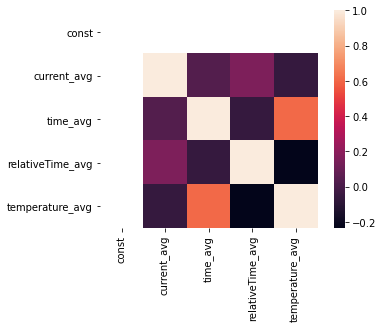

In [62]:
import seaborn as sns
sns.heatmap(X_test.corr(), vmax=1, square=True)

In [277]:
def plot_fit(Y, Yhat):
    plt.scatter(Y, Yhat,  color='black')
    plt.xlabel("true outcome Y")
    plt.ylabel("predicted outcome Yhat")
   
    plt.show()

In [ ]:
# length of fluctuation 
r_sort = np.array(r)

index = r_sort.argsort()

r_sort = r_sort[index]

index_min = index[0:21]
r_min = r_sort[0:21]

index_max = index[163:184]
r_max = r_sort[163:184]

min_max_df = pd.DataFrame()
min_max_df['index_min'] = index_min
min_max_df['r_min'] = r_min
min_max_df['index_max'] = index_max
min_max_df['r_max'] = r_max
#min_max_df.columns = ['r_min','index_min','r_max','index_max']

